In this project, I use Convolutional Neural Networks to detect metastatic cancer in histopathology image patches from the PCam dataset. The main goal is to build and compare a few CNN models, understand how their performance differs, and generate predictions for submission.

In [3]:
# Imports

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from PIL import Image

In [4]:
# Random Seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

#Path to folder
DATA_DIR = "/kaggle/input/histopathologic-cancer-detection"

print("Files in input directory", os.listdir(DATA_DIR))


Files in input directory ['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [5]:
# Load labels CSV
train_csv_path = os.path.join(DATA_DIR, "train_labels.csv")
df = pd.read_csv(train_csv_path)

df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


**EDA**

In this section, we explore the dataset structure, label distribution, and visualize sample images to understand the problem before modeling.


EDA

In [6]:
#Basic Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [7]:
#Describe stats
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
#Missing values
df.isnull().sum()

id       0
label    0
dtype: int64

In [9]:
#Duplicates
df.duplicated().sum()

0

In [10]:
#Label counts
df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

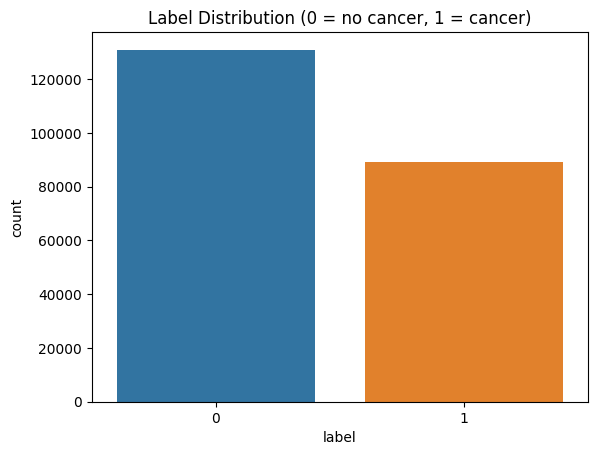

In [11]:
#Plot label distribution
sns.countplot(data=df, x='label')
plt.title("Label Distribution (0 = no cancer, 1 = cancer)")
plt.show()

In [12]:
#image path column
df['path'] = df['id'].apply(lambda x: os.path.join(DATA_DIR,"train", f"{x}.tif"))
df.head()

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


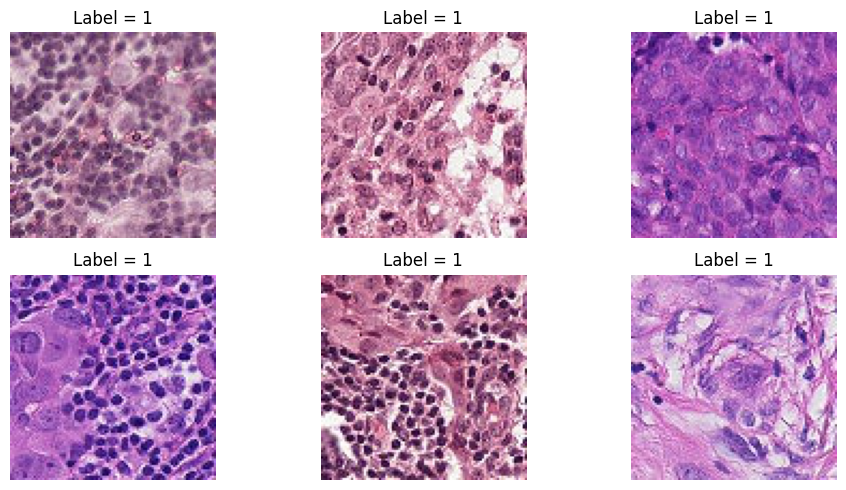

In [13]:
#Images with label 1
pos_imgs = df[df['label'] == 1].sample(6, random_state=SEED)
plt.figure(figsize=(10, 5))
for i, row in enumerate(pos_imgs.itertuples(), 1):
    img = Image.open(row.path)
    plt.subplot( 2, 3, i)
    plt.imshow(img)
    plt.title("Label = 1")
    plt.axis("off")

plt.tight_layout()
plt.show()

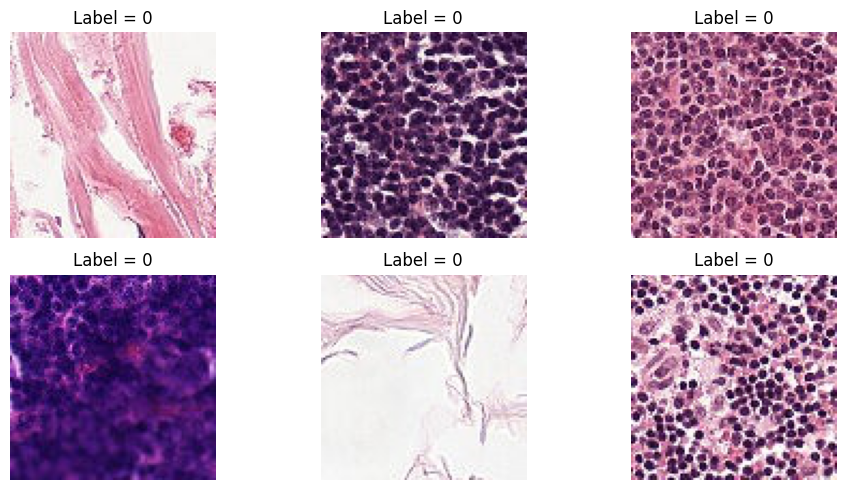

In [14]:
#Images with label 0
pos_imgs = df[df['label'] == 0].sample(6, random_state=SEED)
plt.figure(figsize=(10, 5))
for i, row in enumerate(pos_imgs.itertuples(), 1):
    img = Image.open(row.path)
    plt.subplot( 2, 3, i)
    plt.imshow(img)
    plt.title("Label = 0")
    plt.axis("off")

plt.tight_layout()
plt.show()

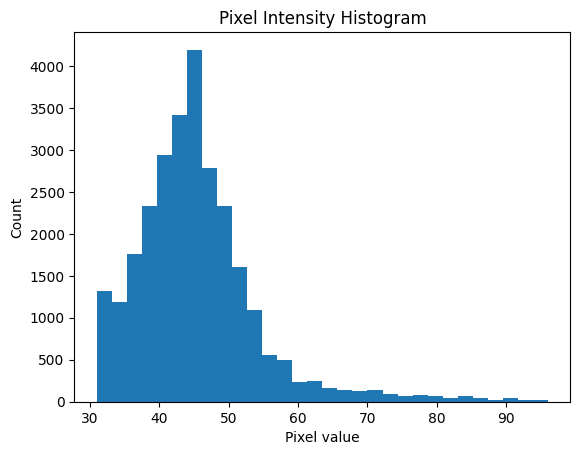

In [15]:
# Pixel intensity histogram
random_row = df.sample(1, random_state=SEED).iloc[0]
img = np.array(Image.open(random_row.path))

plt.hist(img.flatten(), bins=30)
plt.title("Pixel Intensity Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Count")
plt.show()

Train and Validation

In [16]:
IMG_SIZE = 96
BATCH_SIZE = 64

#train and validation split
train_df, val_df = train_test_split(df, test_size=0.2,stratify=df["label"],random_state=SEED)

len(train_df), len(val_df)

(176020, 44005)

In [17]:
#ImageDataGenerator for train and validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen= ImageDataGenerator(rescale=1.0 / 255.0)

In [18]:
#Convert labels to string
train_df['label_str'] = train_df['label'].astype(str)
val_df['label_str'] = val_df['label'].astype(str)

In [19]:
# Train and Val Generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size= BATCH_SIZE,
    shuffle=True,
    validate_filenames=False
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label_str',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary',
    batch_size= BATCH_SIZE,
    shuffle=False,
    validate_filenames=False
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [20]:
#Test dataframe and generator
test_dir = os.path.join(DATA_DIR, "test")
test_ids = [f.replace(".tif","") for f in os.listdir(test_dir)]
test_df = pd.DataFrame({"id": test_ids})
test_df['path'] = test_df['id'].apply(lambda x: os.path.join(test_dir, f"{x}.tif"))

test_df.head()

,id,path
0,a7ea26360815d8492433b14cd8318607bcf99d9e,/kaggle/input/histopathologic-cancer-detection...
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,/kaggle/input/histopathologic-cancer-detection...
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,/kaggle/input/histopathologic-cancer-detection...
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,/kaggle/input/histopathologic-cancer-detection...
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,/kaggle/input/histopathologic-cancer-detection...


In [21]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode=None,
    batch_size= BATCH_SIZE,
    shuffle=False,
    validate_filenames=False
)

Found 57458 non-validated image filenames.


In [22]:
#Sanity check
batch_images, batch_labels = next(train_generator)
print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)

Batch images shape: (64, 96, 96, 3)
Batch labels shape: (64,)


**Baseline CNN Model**

A simple CNN architecture is first trained as a baseline to understand the initial performance of the model.
It is built with a small number of convolutional layers and a set of fully connected layers at the end.


In [23]:
#Baseline CNN
def build_baseline_cnn(input_shape=(IMG_SIZE,IMG_SIZE, 3)):
    model = Sequential()

    #Block 1
    model.add(Conv2D(32,(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    
    #Block 2
    model.add(Conv2D(64,(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    
    #Block 3
    model.add(Conv2D(128,(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    
    #Dense part
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    
    #Output
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

baseline_model = build_baseline_cnn()
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766505687.436364      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

**Deeper CNN Model**
A deeper CNN architecture is tested to capture more complex image features.
This version includes batch normalization and global average pooling to improve stability and generalization.


In [24]:
#Deeper CNN
def build_deeper_cnn(input_shape=(IMG_SIZE,IMG_SIZE, 3)):
    model = Sequential()

    #Block 1
    model.add(Conv2D(32,(3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(MaxPooling2D(2, 2))
    
    #Block 2
    model.add(Conv2D(64,(3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(MaxPooling2D(2, 2))
    
    #Block 3
    model.add(Conv2D(128,(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(MaxPooling2D(2, 2))
    
    #Block 4
    model.add(Conv2D(256,(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(MaxPooling2D(2, 2))
    
    #Global avg pooling
    model.add(GlobalAveragePooling2D())
    
    #Dense part
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    #Output
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

deeper_model = build_deeper_cnn()
deeper_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Training and Basic Tuning

In [25]:
#Callbacks and model paths
baseline_path = "/kaggle/working/baseline_cnn_best.h5"
deeper_path = "/kaggle/working/deeper_cnn_best.h5"
baseline_epochs_done = 0
deeper_epochs_done = 0

baseline_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        baseline_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

deeper_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        deeper_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [26]:
if os.path.exists(baseline_path):
    baseline_model = load_model(baseline_path)
    print("Loaded baseline from checkpoint")
else:
    baseline_model = build_baseline_cnn()
    print("Created new baseline model")

baseline_model.summary()

Created new baseline model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#Training baseline model

EPOCHS_BASELINE = 6

history_baseline = baseline_model.fit(
    train_generator,
    epochs=EPOCHS_BASELINE,
    validation_data=val_generator,
    callbacks=baseline_callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6


I0000 00:00:1766505692.230164     107 service.cc:148] XLA service 0x7c06e4002930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766505692.230852     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766505692.594032     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2751 ━━━━━━━━━━━━━━━━━━━━ 4:06:28 5s/step - accuracy: 0.6094 - loss: 0.6762

I0000 00:00:1766505695.338364     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.7690 - loss: 0.4901
Epoch 1: val_loss improved from inf to 0.49702, saving model to /kaggle/working/baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 2476s 898ms/step - accuracy: 0.7690 - loss: 0.4901 - val_accuracy: 0.7963 - val_loss: 0.4970
Epoch 2/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8485 - loss: 0.3566
Epoch 2: val_loss improved from 0.49702 to 0.33180, saving model to /kaggle/working/baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 761s 277ms/step - accuracy: 0.8485 - loss: 0.3566 - val_accuracy: 0.8668 - val_loss: 0.3318
Epoch 3/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8739 - loss: 0.3077
Epoch 3: val_loss improved from 0.33180 to 0.28212, saving model to /kaggle/working/baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 671s 244ms/step - accuracy: 0.8739 - loss: 0.3077 - val_accuracy: 0.8844 - val_loss: 0.2821
Epoch 4/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8858 - loss: 0.2804
Epoch 4: val_loss improved from 0.28212 to 0.26355, saving model to /kaggle/working/baseline_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 685s 249ms/step - accuracy: 0.8858 - loss: 0.2804 - val_accuracy: 0.8918 - val_loss: 0.2636
Epoch 5/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8943 - loss: 0.2638
Epoch 5: val_loss did not improve from 0.26355
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 759s 276ms/step - accuracy: 0.8943 - loss: 0.2638 - val_accuracy: 0.8885 - val_loss: 0.2756
Epoch 6/6
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8989 - loss: 0.2540
Epoch 6: val_loss did not improve from 0.26355
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 698s 254ms/step - accuracy: 0.8989 - loss: 0.2540 - val_accuracy: 0.8921 - val_loss: 0.2696


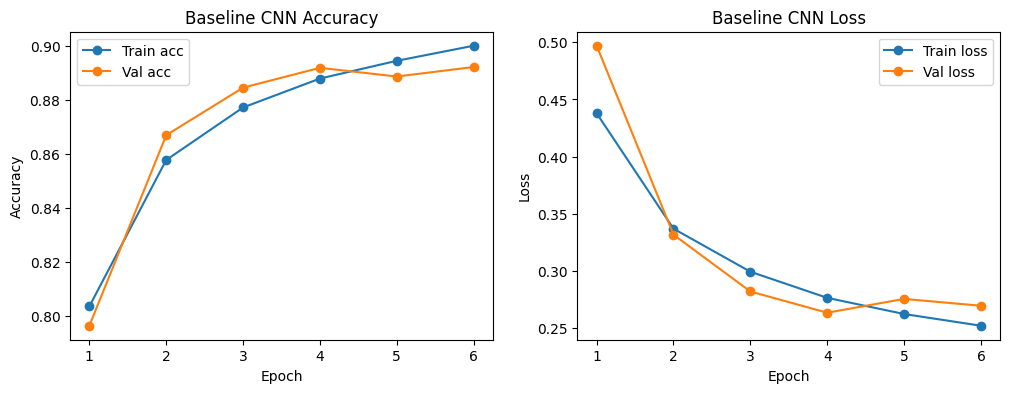

In [28]:
#Helper to plot training history
def plot_training_history(history, title_prefix=""):
    acc = history.history.get('accuracy',[])
    val_acc = history.history.get('val_accuracy',[])
    loss = history.history.get('loss',[])
    val_loss = history.history.get('val_loss',[])
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))
    
    #Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'o-', label='Train acc')
    plt.plot(epochs, val_acc, 'o-', label='Val acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    #Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'o-', label='Train loss')
    plt.plot(epochs, val_loss, 'o-', label='Val loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history_baseline, title_prefix='Baseline CNN')


In [29]:
#Validatoion AUC for baseline model
val_generator.reset()
val_preds_baseline= baseline_model.predict(val_generator)
val_true = val_df['label'].values

baseline_auc = roc_auc_score(val_true, val_preds_baseline)
print("Baseline model validation AUC:", baseline_auc)
print("Best val accuracy (baseline):",max(history_baseline.history['val_accuracy']))

688/688 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step
Baseline model validation AUC: 0.9610263128043146
Best val accuracy (baseline): 0.8920577168464661


In [30]:
if os.path.exists(deeper_path):
    deeper_model = load_model(deeper_path)
    print("Loaded deeper model from checkpoint")
else:
    deeper_model = build_deeper_cnn()
    print("Created new deeper model model")

deeper_model.summary()

Created new deeper model model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,385 (1.74 MB)

 Trainable params: 455,425 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [31]:
#Train deeper model

EPOCHS_DEEPER = 3

history_deeper = deeper_model.fit(
    train_generator,
    epochs=EPOCHS_DEEPER,
    validation_data=val_generator,
    callbacks=deeper_callbacks
)

Epoch 1/3
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8169 - loss: 0.4170
Epoch 1: val_loss improved from inf to 0.75602, saving model to /kaggle/working/deeper_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 735s 265ms/step - accuracy: 0.8169 - loss: 0.4170 - val_accuracy: 0.7229 - val_loss: 0.7560
Epoch 2/3
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8673 - loss: 0.3156
Epoch 2: val_loss improved from 0.75602 to 0.42710, saving model to /kaggle/working/deeper_cnn_best.h5


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 749s 272ms/step - accuracy: 0.8673 - loss: 0.3156 - val_accuracy: 0.8150 - val_loss: 0.4271
Epoch 3/3
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8852 - loss: 0.2793
Epoch 3: val_loss did not improve from 0.42710
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 761s 277ms/step - accuracy: 0.8852 - loss: 0.2793 - val_accuracy: 0.8102 - val_loss: 0.4439


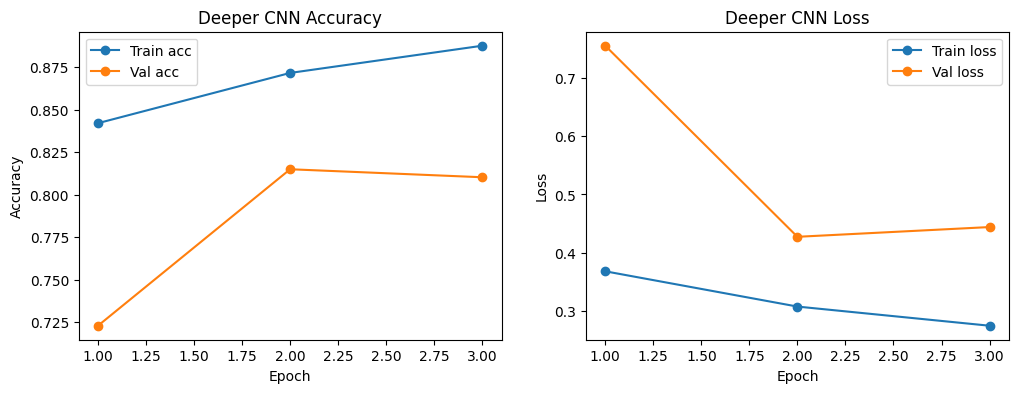

In [32]:
#Plot deeper model history
plot_training_history(history_deeper, title_prefix='Deeper CNN')

In [33]:
#Validation AUC for deeper model

val_generator.reset()
val_preds_deeper = deeper_model.predict(val_generator)

deeper_auc = roc_auc_score(val_true, val_preds_deeper)
print("Deeper model validation AUC:", deeper_auc)
print("Best val accuracy (deeper):", max(history_deeper.history['val_accuracy']))

688/688 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step
Deeper model validation AUC: 0.9362687260501785
Best val accuracy (deeper): 0.8149528503417969


In [36]:
print("=== Baseline CNN ===")
print("Val AUC:", baseline_auc)
print("Best val accuracy:", max(history_baseline.history["val_accuracy"]))

print("\n=== Deeper CNN ===")
print("Val AUC:", deeper_auc)
print("Best val accuracy:", max(history_deeper.history["val_accuracy"]))

# pick best model by AUC
best_model_name = "deeper" if deeper_auc >= baseline_auc else "baseline"
print("\nBest model selected:", best_model_name)

=== Baseline CNN ===
Val AUC: 0.9610263128043146
Best val accuracy: 0.8920577168464661

=== Deeper CNN ===
Val AUC: 0.9362687260501785
Best val accuracy: 0.8149528503417969

Best model selected: baseline


In [37]:
# Load best weights for the selected model
if best_model_name == "deeper":
    best_model = build_deeper_cnn()
    best_model.load_weights(deeper_path)
else:
    best_model = build_baseline_cnn()
    best_model.load_weights(baseline_path)

# Predict on test
test_generator.reset()
test_preds = best_model.predict(test_generator).ravel()

print("Preds sample:", test_preds[:10])
print("Preds min/max:", test_preds.min(), test_preds.max())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 552s 614ms/step
Preds sample: [0.30099657 0.03563943 0.02918034 0.3179257  0.12655075 0.99044025
 0.06808992 0.69921076 0.08705153 0.1221452 ]
Preds min/max: 1.6472062e-15 1.0


In [39]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "label": test_preds
})

submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.300997
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.035639
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.029180
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.317926
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.126551


**Conclusion**

The baseline CNN is good as a solid starting point, while the deeper model shows better validation performance, though it requires more training time.
Because of computational limits, both models were trained for a small number of epochs.

In [43]:
submission_path = "/kaggle/working/submission.csv"
submission.to_csv(submission_path, index=False)
print("Submission saved to:", submission_path)

Submission saved to: /kaggle/working/submission.csv
